In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix, balanced_accuracy_score, roc_auc_score, roc_curve
from bayes_opt import BayesianOptimization

import warnings
warnings.filterwarnings('ignore') 

# Loading and examining the dataset

In [2]:
df = pd.read_csv("./c2.csv") # Importing data set

df.head()

,id,age,checking_status,class,credit_amount,credit_history,duration,employment,existing_credits,feat01,...,job,num_dependents,other_parties,other_payment_plans,own_telephone,personal_status,property_magnitude,purpose,residence_since,savings_status
0,1,48,'0<=X<200',good,2049,'critical/other existing credit',18,'>=7',2,0.301261,...,'unskilled resident',1,guarantor,bank,yes,'female div/dep/mar','real estate',radio/tv,4,'<100'
1,2,32,'<0',bad,1953,'existing paid',24,'<1',1,0.528398,...,skilled,1,none,none,none,'male div/sep','life insurance',radio/tv,3,'<100'
2,3,46,'<0',bad,6463,'critical/other existing credit',48,'>=7',2,0.431464,...,skilled,1,none,none,yes,'male single','no known property','used car',4,'<100'
3,4,24,'0<=X<200',bad,1365,'existing paid',8,'1<=X<4',1,0.555267,...,skilled,1,none,none,none,'female div/dep/mar','real estate',furniture/equipment,4,'<100'
4,5,36,'<0',good,1716,'existing paid',15,'<1',1,0.502080,...,skilled,1,none,none,none,'male single','real estate','new car',3,'<100'


The variables can be summarized as follows:
- **`id`**: Discrete numerical, unique identifier for records.
- **`age`**: Continuous numerical, represents age in years.
- **`checking_status`**: Categorical, represents bank account status.
- **`class`**: Categorical, target variable indicating classification (e.g., "good" or "bad").
- **`credit_amount`**: Continuous numerical, represents the credit amount requested.
- **`credit_history`**: Categorical, details the credit history.
- **`duration`**: Continuous numerical, represents the credit duration in months.
- **`employment`**: Categorical, employment duration grouped into categories.
- **`existing_credits`**: Discrete numerical, number of existing credits at the bank.
- **`feat01`** to **`feat10`**: Continuous numerical, feature variables with floating-point values.
- **`foreign_worker`**: Categorical, indicates if the individual is a foreign worker.
- **`housing`**: Categorical, represents the type of housing (e.g., "own," "rent").
- **`installment_commitment`**: Discrete numerical, proportion of installment commitment.
- **`job`**: Categorical, describes job classification.
- **`num_dependents`**: Discrete numerical, number of dependents.
- **`other_parties`**: Categorical, indicates involvement of other financial parties.
- **`other_payment_plans`**: Categorical, describes additional payment plans.
- **`own_telephone`**: Categorical, indicates possession of a telephone.
- **`personal_status`**: Categorical, represents personal status and gender.
- **`property_magnitude`**: Categorical, details the property type.
- **`purpose`**: Categorical, represents the purpose of the credit.
- **`residence_since`**: Discrete numerical, years of residence in the current location.
- **`savings_status`**: Categorical, indicates the status of savings accounts.

In [31]:
(df.isna().sum()/df.shape[0])*100

id                        0.0
age                       0.0
checking_status           0.0
class                     0.0
credit_amount             0.0
credit_history            0.0
duration                  0.0
employment                0.0
existing_credits          0.0
feat01                    0.0
feat02                    0.0
feat03                    0.0
feat04                    0.0
feat05                    0.0
feat06                    0.0
feat07                    0.0
feat08                    0.0
feat09                    0.0
feat10                    0.0
foreign_worker            0.0
housing                   0.0
installment_commitment    0.0
job                       0.0
num_dependents            0.0
other_parties             0.0
other_payment_plans       0.0
own_telephone             0.0
personal_status           0.0
property_magnitude        0.0
purpose                   0.0
residence_since           0.0
savings_status            0.0
dtype: float64

No NAs seem to be present in the dataset. This will be further verified below.

In [32]:
df.duplicated().sum()

0

Duplicated rows are also not present.

In [33]:
df.dropna(inplace=True) #just in case

Columns will now be assigned to categorical and numerical. Note that this is not their final assignment.

In [34]:
cat_features = [feature for feature in df.columns if df[feature].dtype=='O']
num_features = [feature for feature in df.columns if df[feature].dtype!='O']

for feature in cat_features:
    print("Total unique features in %s : %s"%(feature,df[feature].nunique()))

Total unique features in checking_status : 4
Total unique features in class : 2
Total unique features in credit_history : 5
Total unique features in employment : 5
Total unique features in foreign_worker : 2
Total unique features in housing : 3
Total unique features in job : 4
Total unique features in other_parties : 3
Total unique features in other_payment_plans : 3
Total unique features in own_telephone : 2
Total unique features in personal_status : 4
Total unique features in property_magnitude : 4
Total unique features in purpose : 10
Total unique features in savings_status : 5


# Exploratory data analysis and variable transformations

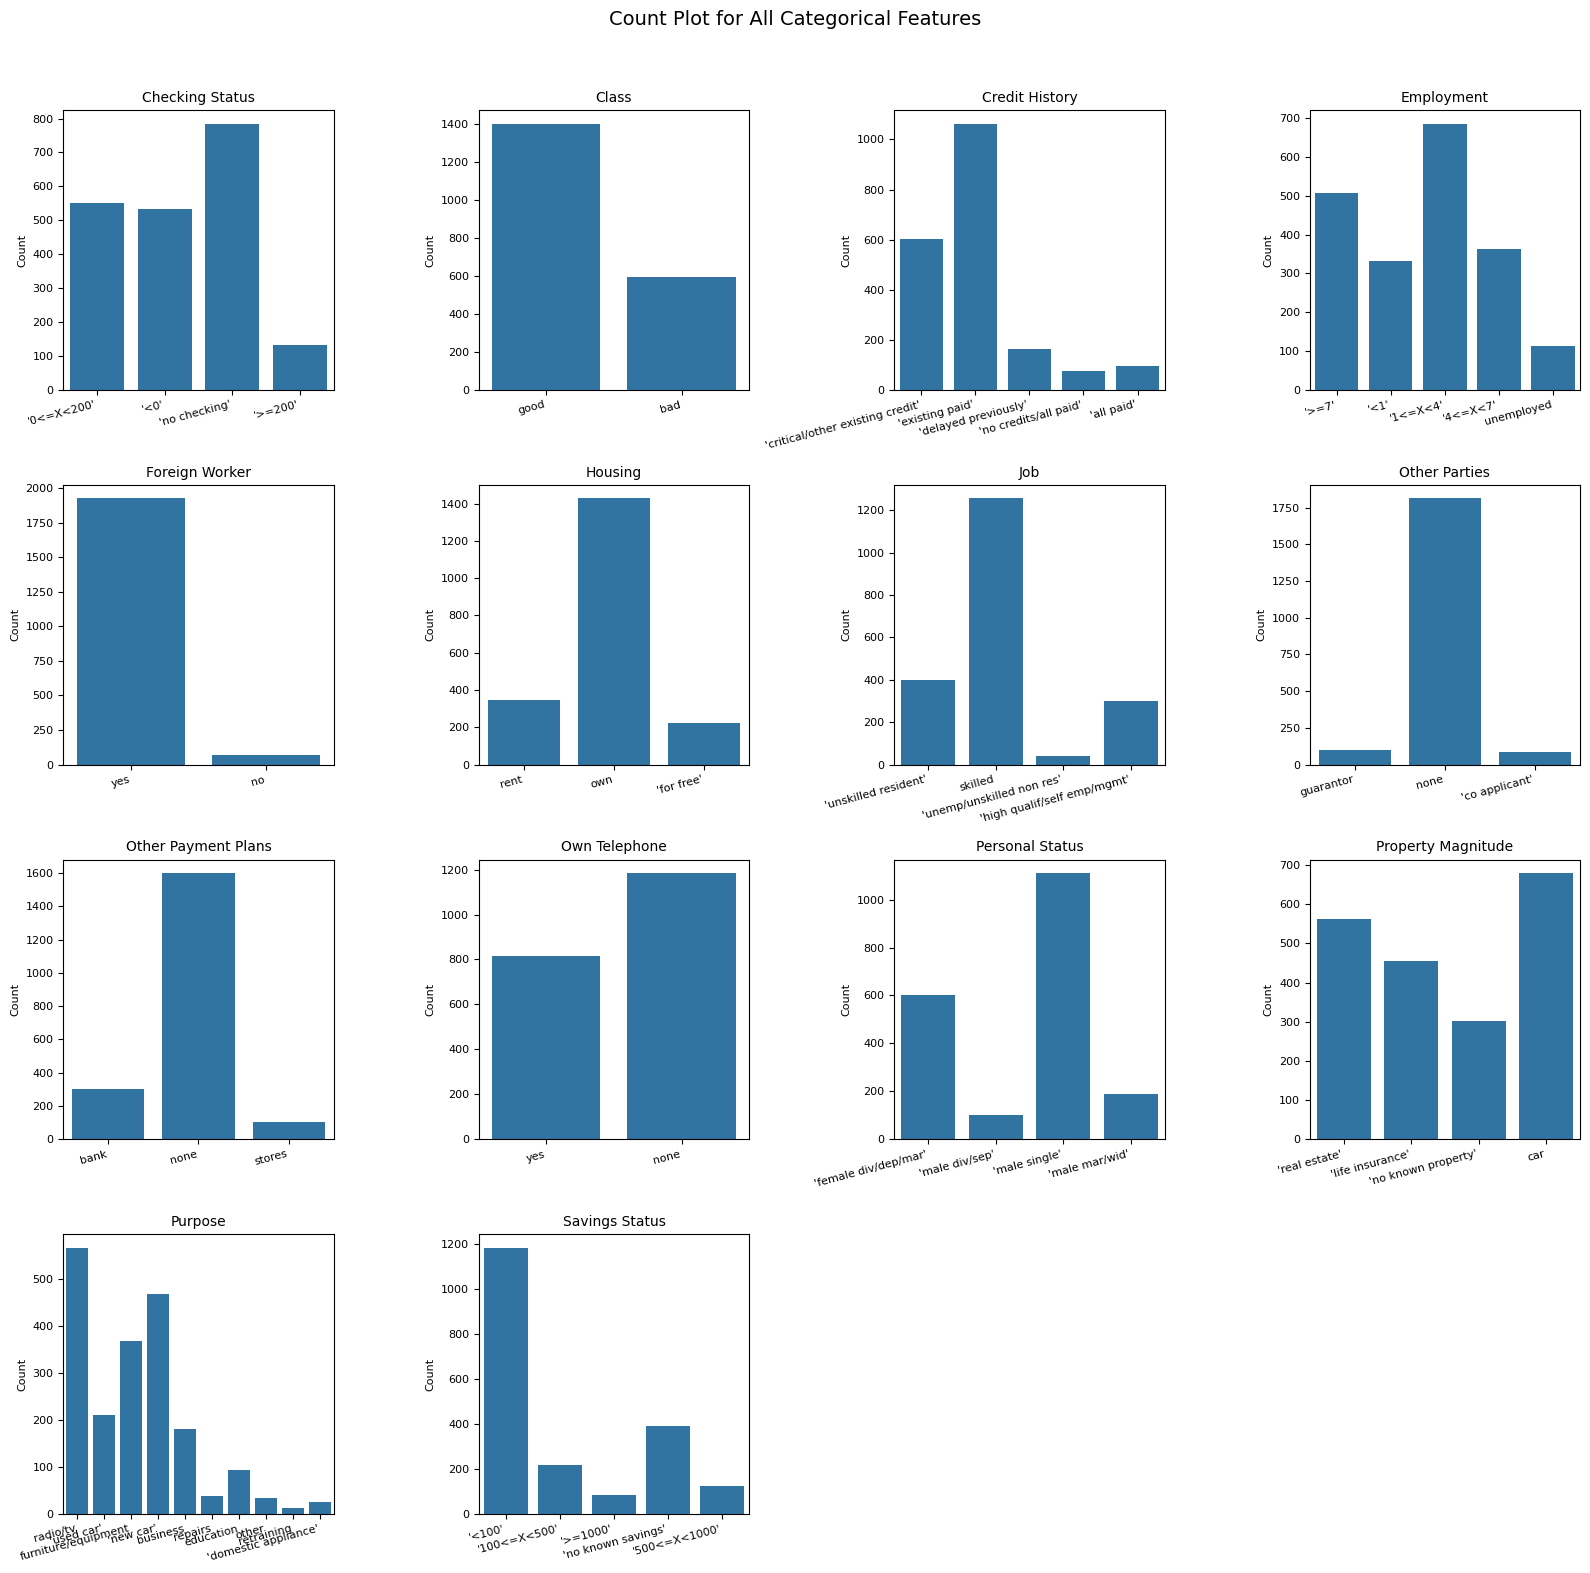

In [35]:
plt.switch_backend('module://matplotlib_inline.backend_inline')

# List of categories and their titles
categories = [
    ("checking_status", "Checking Status"),
    ("class", "Class"),
    ("credit_history", "Credit History"),
    ("employment", "Employment"),
    ("foreign_worker", "Foreign Worker"),
    ("housing", "Housing"),
    ("job", "Job"),
    ("other_parties", "Other Parties"),
    ("other_payment_plans", "Other Payment Plans"),
    ("own_telephone", "Own Telephone"),
    ("personal_status", "Personal Status"),
    ("property_magnitude", "Property Magnitude"),
    ("purpose", "Purpose"),
    ("savings_status", "Savings Status"),
]

def create_single_grid(categories, title, nrows, ncols, figsize):
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    fig.suptitle(title, fontsize=14)
    for i, (col, col_title) in enumerate(categories):
        row, col_index = divmod(i, ncols)
        ax = axes[row, col_index]
        sns.countplot(ax=ax, data=df, x=col)
        ax.set_title(col_title, fontsize=10)
        ax.set_xlabel("")
        ax.set_ylabel("Count", fontsize=8)
        ax.tick_params(axis='x', labelsize=8)
        ax.tick_params(axis='y', labelsize=8)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha="right")

    for j in range(len(categories), nrows * ncols):
        fig.delaxes(axes.flatten()[j])
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

nrows = 4
ncols = 4  
figsize = (16, 16)  


create_single_grid(categories, "Count Plot for All Categorical Features", nrows, ncols, figsize)


No NAs are visible on the graph, confirming the previous thesis. The graphs above also point towards a class imbalance.

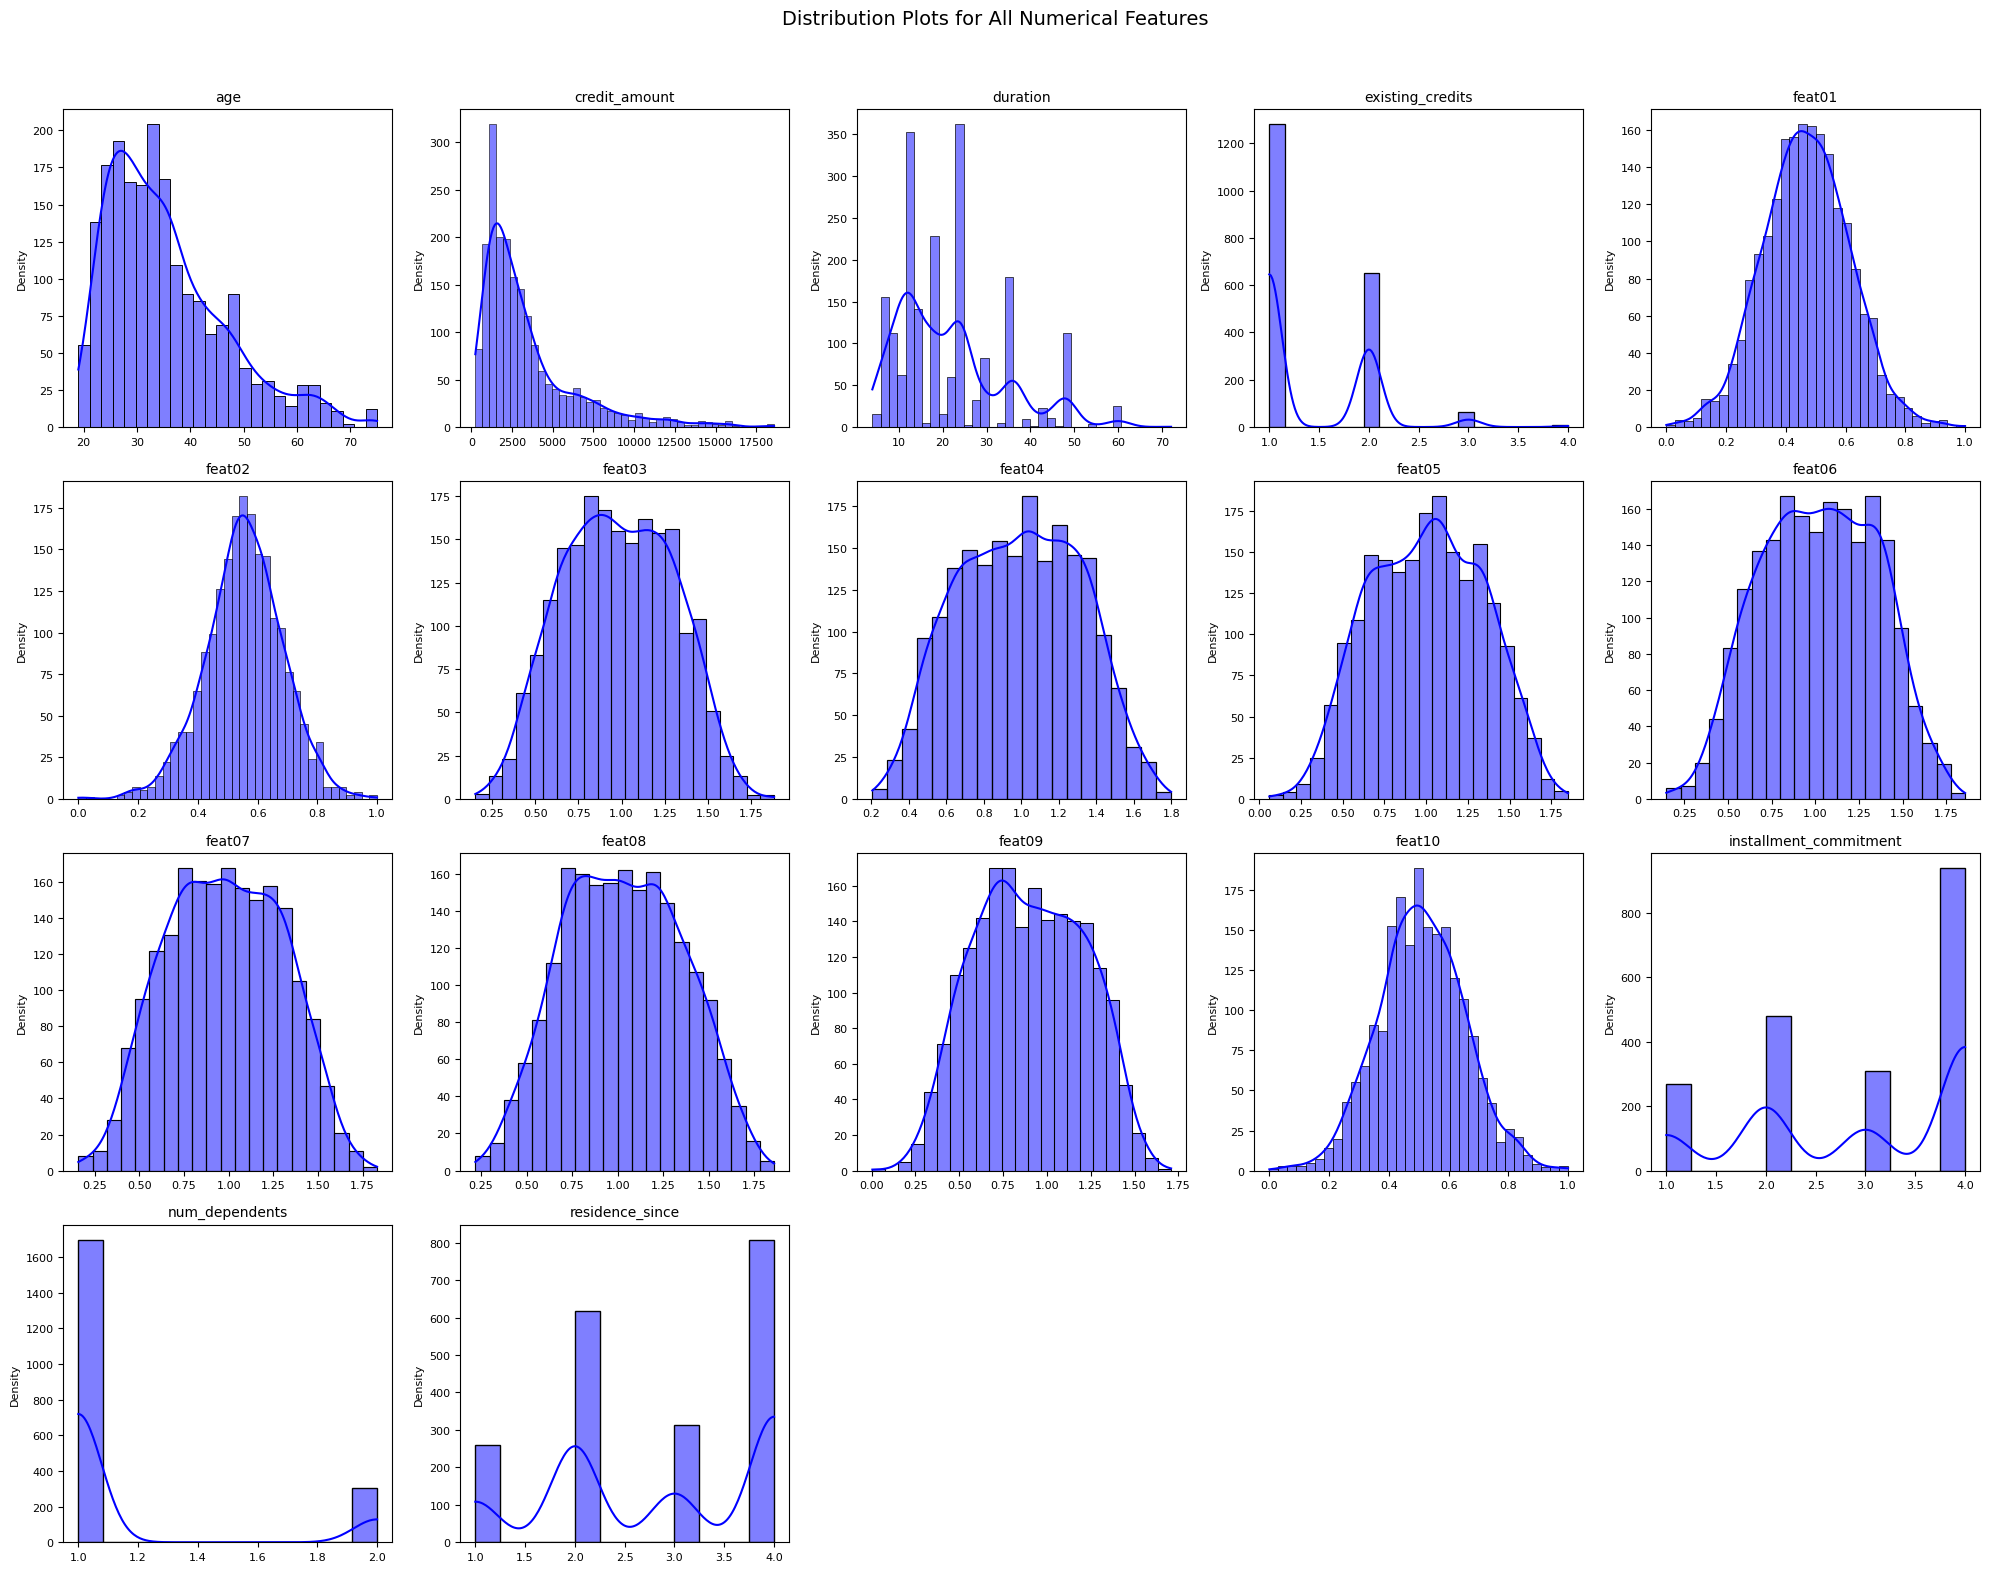

In [36]:
# List of numerical columns
numerical_columns = [
    'age', 'credit_amount', 'duration', 'existing_credits', 'feat01', 'feat02', 
    'feat03', 'feat04', 'feat05', 'feat06', 'feat07', 'feat08', 'feat09', 
    'feat10', 'installment_commitment', 'num_dependents', 'residence_since'
]


def create_single_distribution_grid(columns, title, nrows, ncols, figsize):
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    fig.suptitle(title, fontsize=14)
    for i, col in enumerate(columns):
        row, col_index = divmod(i, ncols)
        ax = axes[row, col_index]
        sns.histplot(df[col], ax=ax, kde=True, color='blue')  # Distribution with KDE
        ax.set_title(col, fontsize=10)
        ax.set_xlabel("")
        ax.set_ylabel("Density", fontsize=8)
        ax.tick_params(axis='x', labelsize=8)
        ax.tick_params(axis='y', labelsize=8)

    for j in range(len(columns), nrows * ncols):
        fig.delaxes(axes.flatten()[j])
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


nrows = 4
ncols = 5  
figsize = (20, 16)  


create_single_distribution_grid(
    numerical_columns, 
    "Distribution Plots for All Numerical Features", 
    nrows=nrows, ncols=ncols, figsize=figsize
)


The variables duration, credit_amount and age exhibit moderate to strong skewness. Thus, log and square root transformations will be applied. Some variables also seem discrete in nature rather than continuous. Factorization will be taken into consideration, although it impedes the performance of some of the models below.

In [37]:
#log/sqrt transformations
df['age_log'] = np.log1p(df['age'])  # log1p to handle zeros safely
df['credit_amount_log'] = np.log1p(df['credit_amount'])

df['duration_sqrt'] = np.sqrt(df['duration'])

#factorization through bins
df['installment_commitment_bin'] = pd.cut(
    df['installment_commitment'], 
    bins=[0, 1.5, 2.5, 3.5, 4.5], 
    labels=['1', '2', '3', '4']
)

df['residence_since_bin'] = pd.cut(
    df['residence_since'], 
    bins=[0, 1.5, 2.5, 3.5, 4.5], 
    labels=['1', '2', '3', '4']
)

The variables will now be added to their respective column pool.

In [38]:
cat_features.append('installment_commitment_bin')
cat_features.append('residence_since_bin')
num_features.append('duration_sqrt')
num_features.append('credit_amount_log')
num_features.append('age_log')

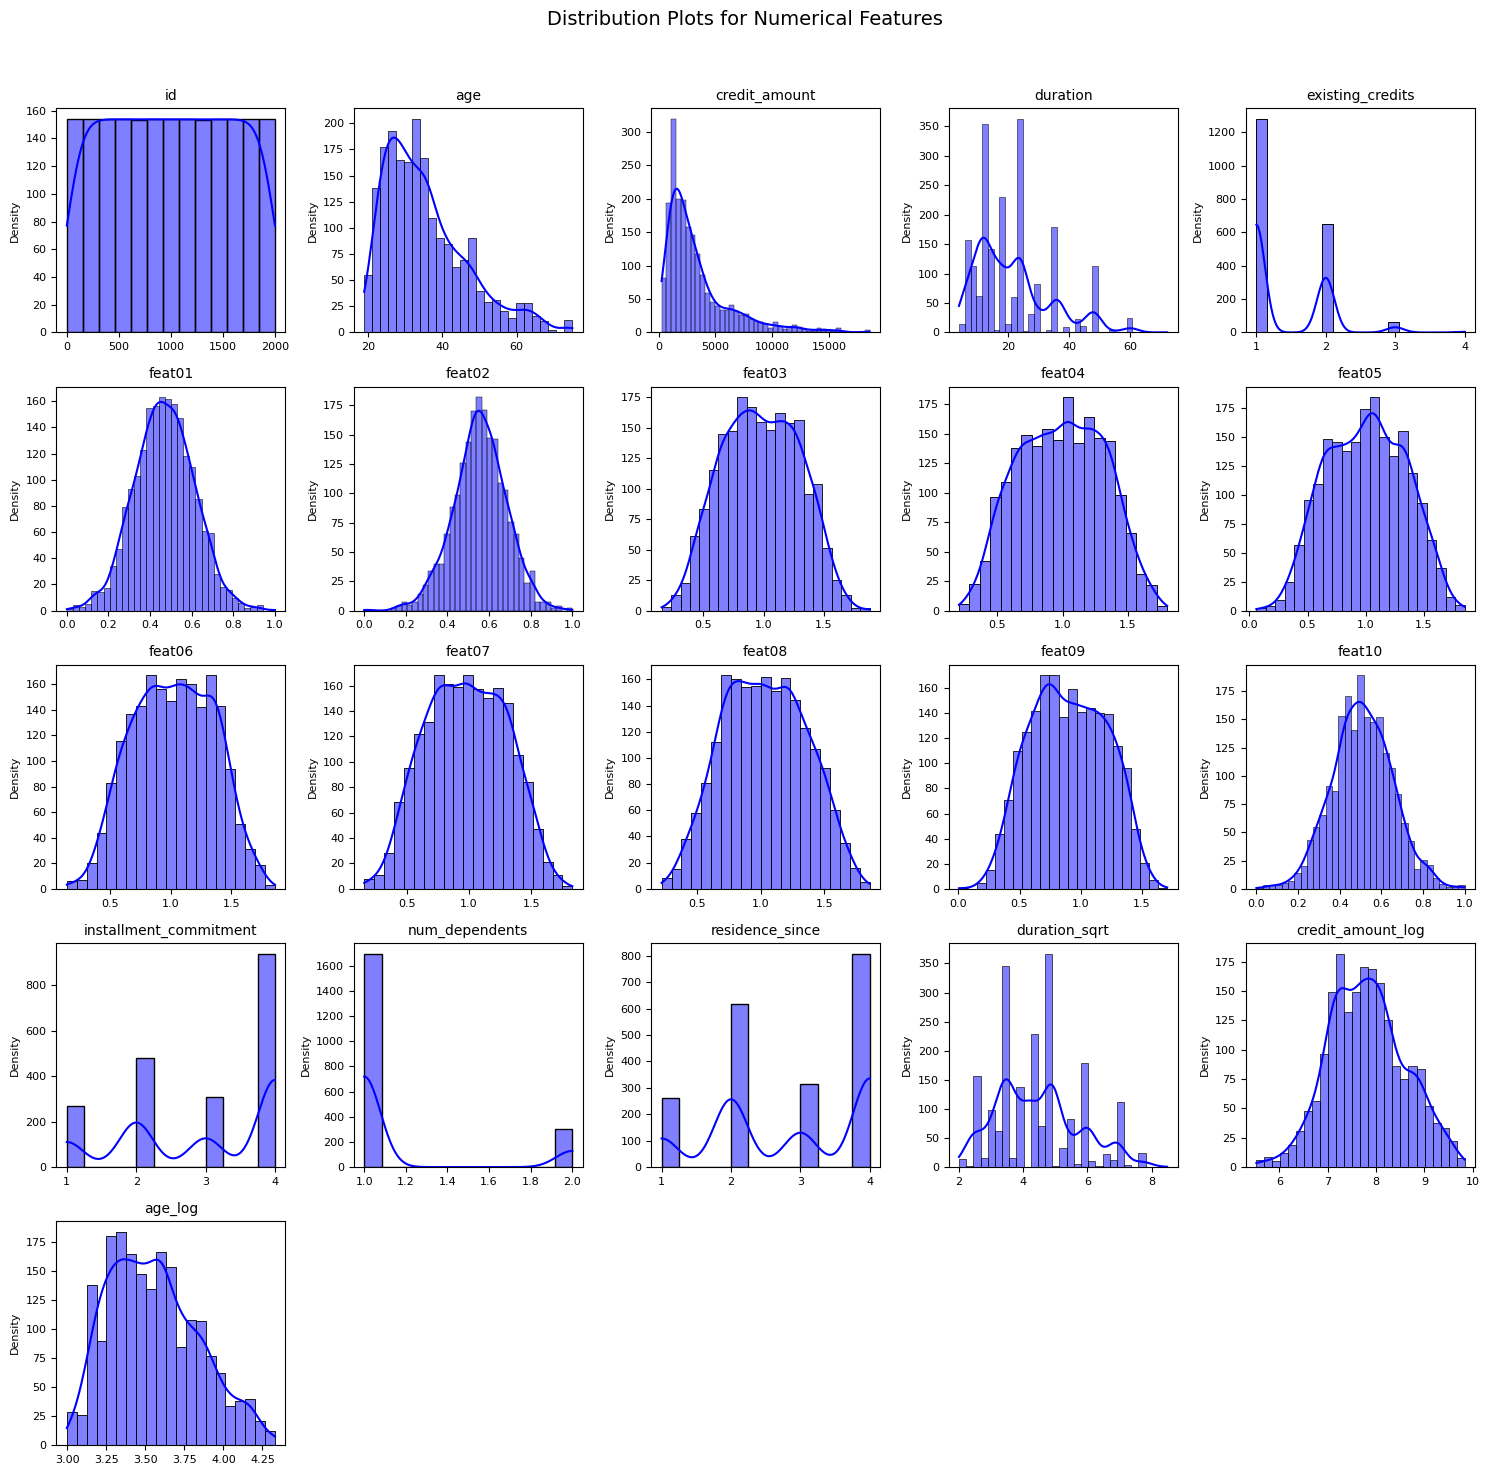

In [39]:
create_single_distribution_grid(
    num_features, 
    "Distribution Plots for Numerical Features", 
    nrows=5, ncols=5, figsize=(15, 15)
)


The transformed variables, although not really normally distributed, exhibit much less of a skewness now. We will remove the initial columns from the numerical column pool.

In [40]:
num_features = [feature for feature in num_features if feature != "age" or "credit_amount" or "duration" or 'installment_commitment' or 'residence_since']

# Modeling

First, we drop ID and the target variable when creating the datasets. ID will not be used at all, while 'class' will get a dataframe of its own.

In [41]:
X = df.drop(['class','id'],axis=1)
y = df['class']

y.head()

0    good
1     bad
2     bad
3     bad
4    good
Name: class, dtype: object

In [42]:
X.head()

,age,checking_status,credit_amount,credit_history,duration,employment,existing_credits,feat01,feat02,feat03,...,personal_status,property_magnitude,purpose,residence_since,savings_status,age_log,credit_amount_log,duration_sqrt,installment_commitment_bin,residence_since_bin
0,48,'0<=X<200',2049,'critical/other existing credit',18,'>=7',2,0.301261,0.531544,0.714063,...,'female div/dep/mar','real estate',radio/tv,4,'<100',3.891820,7.625595,4.242641,3,4
1,32,'<0',1953,'existing paid',24,'<1',1,0.528398,0.355970,0.943270,...,'male div/sep','life insurance',radio/tv,3,'<100',3.496508,7.577634,4.898979,4,3
2,46,'<0',6463,'critical/other existing credit',48,'>=7',2,0.431464,0.540609,1.049077,...,'male single','no known property','used car',4,'<100',3.850148,8.774004,6.928203,4,4
3,24,'0<=X<200',1365,'existing paid',8,'1<=X<4',1,0.555267,0.441994,0.546877,...,'female div/dep/mar','real estate',furniture/equipment,4,'<100',3.218876,7.219642,2.828427,3,4
4,36,'<0',1716,'existing paid',15,'<1',1,0.502080,0.528704,0.729171,...,'male single','real estate','new car',3,'<100',3.610918,7.448334,3.872983,2,3


The training/testing split is initiated. We go for the standard 80/20 split.

In [43]:
x_train_pre,x_test,y_train_pre,y_test = train_test_split(X,y,test_size=0.2,random_state=40)

The target variable has been separated from the rest of the dataset. This means we now have to remove it from the categorical variable pool.

In [44]:
cat_features = [feature for feature in cat_features if feature != "class"] #usuń class z cat features


The target variable training and testing sets have to be encoded into dummies, meaning instead of taking values of good and bad, they take values of good = True/False

In [45]:
y_train = pd.get_dummies(y_train_pre,drop_first=True)

y_train.head()

,good
1239,True
426,False
1249,True
727,False
800,True


In [46]:
y_test = pd.get_dummies(y_test,drop_first=True)

y_test.head()

,good
423,True
1495,True
1618,True
1099,True
1307,False


We target encode the categorical variables for the logit model and SVC. The reasoning behind it is that those methods handle high dimensionality poorly. On the other hand, for the tree based models, one hot encoding will be better.

In [47]:
from category_encoders import TargetEncoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False,drop='first')
tar = TargetEncoder()

In [48]:
x_train_pre_cat = ohe.fit_transform(x_train_pre[cat_features]) # one hot
x_train_pre_cat_tar = tar.fit_transform(x_train_pre[cat_features], y_train) # target


Very important: we do not use a separate transformer function on the test sets. We also did not use the functions on the joined dataset. Rather, we use the function which was trained on the training sets. This ensures no data leakage on one hand, and no irratonal transformations on the other. The same can be said about the scaler used below.

In [49]:
x_test_pre_cat = ohe.transform(x_test[cat_features])
x_test_pre_cat_tar = tar.transform(x_test[cat_features])

In [50]:
x_test_pre_cat.shape,x_train_pre_cat.shape #column counts match

((400, 47), (1600, 47))

In [51]:
x_test_pre_cat_tar.shape,x_train_pre_cat_tar.shape #here they also do

((400, 15), (1600, 15))

For the logit model and SVC, scaling of numerical variables has to be introduced to diminish the problem of exaggerated variable importance. We decide not to perform this for tree-based models.

In [52]:
sclr = StandardScaler()

In [53]:
num_features = [feature for feature in num_features if feature != "id"] #usuń id z num features

In [54]:
x_train_pre_num_scaled= sclr.fit_transform(x_train_pre[num_features])
x_train_pre_num= x_train_pre[num_features]

In [55]:
x_test_pre_num_scaled = sclr.transform(x_test[num_features])
x_test_pre_num = x_test[num_features]

Datasets of both categorical and numerical variables are now being combined.

In [56]:
x_train = np.column_stack((x_train_pre_num, x_train_pre_cat))
x_test = np.column_stack((x_test_pre_num ,x_test_pre_cat))
x_train_lsvc = np.column_stack((x_train_pre_num_scaled, x_train_pre_cat_tar)) #lsvc: logit - svc
x_test_lsvc = np.column_stack((x_test_pre_num_scaled ,x_test_pre_cat_tar))

Examining the class balance is also worth our time, as some models can handle class weights.

In [57]:
y_train.value_counts()/y_train.shape[0]

good 
True     0.699375
False    0.300625
Name: count, dtype: float64

### Logit

We will now create a simple logit model, along

In [110]:
lg_clss = LogisticRegression(class_weight = 'balanced')

In [111]:
lg_clss.fit(x_train_lsvc,y_train)

LogisticRegression(class_weight='balanced')

In [112]:
y_pred = lg_clss.predict(x_test_lsvc)

In [113]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       False       0.62      0.73      0.67       116
        True       0.88      0.82      0.85       284

    accuracy                           0.79       400
   macro avg       0.75      0.77      0.76       400
weighted avg       0.81      0.79      0.80       400



In [114]:
confusion_matrix(y_test,y_pred)

array([[ 85,  31],
       [ 52, 232]], dtype=int64)

In [115]:
accuracy_score(y_test,y_pred)*100

79.25

In [116]:
balanced_accuracy_score(y_test,y_pred)*100

77.48300145701796

### SVC

To further handle the class imbalance, we use SMOTE oversampling, generating synthetic rows of the underrepresented class.

In [66]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_lsvc, y_train)

In [67]:
svc = SVC(class_weight='balanced')

In [68]:
svc.fit(x_train_resampled, y_train_resampled)

SVC(class_weight='balanced')

In [69]:
y_pred = svc.predict(x_test_lsvc)

In [70]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       False       0.59      0.60      0.60       116
        True       0.84      0.83      0.83       284

    accuracy                           0.76       400
   macro avg       0.71      0.72      0.71       400
weighted avg       0.76      0.76      0.76       400



In [45]:
confusion_matrix(y_test,y_pred)

array([[ 70,  46],
       [ 49, 235]], dtype=int64)

In [46]:
accuracy_score(y_test,y_pred)*100

76.25

In [47]:
balanced_accuracy_score(y_test,y_pred)*100

71.54565322972317

In [50]:
# Function to optimize
def svc_evaluate(C, gamma):
    model = SVC(C=C, gamma=gamma, kernel='rbf', probability=True)
    scores = cross_val_score(model, x_train_resampled, y_train_resampled, cv=3, scoring='roc_auc')
    return scores.mean()

# Define search space
pbounds = {
    'C': (0.1, 1000),
    'gamma': (0.0001, 1.0),
}

# Run Bayesian Optimization
optimizer = BayesianOptimization(
    f=svc_evaluate,
    pbounds=pbounds,
    random_state=42,
    verbose=2,
)

optimizer.maximize(init_points=10, n_iter=30)

# Print best parameters
print("Best Parameters:", optimizer.max)

|   iter    |  target   |     C     |   gamma   |
-------------------------------------------------
| 1         | 0.9587    | 374.6     | 0.9507    |
| 2         | 0.9607    | 732.0     | 0.5987    |
| 3         | 0.9679    | 156.1     | 0.1561    |
| 4         | 0.9589    | 58.18     | 0.8662    |
| 5         | 0.9594    | 601.2     | 0.7081    |
| 6         | 0.9587    | 20.68     | 0.9699    |
| 7         | 0.9672    | 832.5     | 0.2124    |
| 8         | 0.9676    | 181.9     | 0.1835    |
| 9         | 0.9618    | 304.3     | 0.5248    |
| 10        | 0.9658    | 432.0     | 0.2913    |
| 11        | 0.9665    | 885.2     | 0.2521    |
| 12        | 0.9617    | 155.0     | 0.5358    |
| 13        | 0.9619    | 101.4     | 0.5217    |
| 14        | 0.9629    | 5.743     | 0.4638    |
| 15        | 0.9598    | 667.6     | 0.6422    |
| 16        | 0.967     | 885.3     | 0.2211    |
| 17        | 0.9614    | 156.2     | 0.5522    |
| 18        | 0.8838    | 156.0     | 0.0006649 |


In [51]:
best_params = optimizer.max['params']
final_svc = SVC(C=best_params['C'], gamma=best_params['gamma'], kernel='rbf', probability=True)
final_svc.fit(x_train_resampled, y_train_resampled)

SVC(C=604.1000998183385, gamma=0.1517651508065645, probability=True)

In [54]:
y_pred_proba = final_svc.predict_proba(x_test_lsvc)[:, 1]  # Get probabilities for the positive class

# Calculate ROC-AUC score
auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {auc:.4f}")

ROC-AUC Score: 0.7725


### Random Forest

In [91]:
rf_forest = RandomForestClassifier(class_weight='balanced') # Defining and fitting Random forest classifier with class weight
rf_forest.fit(x_train_lsvc, y_train)

RandomForestClassifier(class_weight={0: 0.3, 1: 0.7})

In [92]:
y_pred = rf_forest.predict(x_test_lsvc)

In [87]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       False       0.87      0.51      0.64       116
        True       0.83      0.97      0.89       284

    accuracy                           0.83       400
   macro avg       0.85      0.74      0.77       400
weighted avg       0.84      0.83      0.82       400



In [93]:
confusion_matrix(y_test,y_pred)

array([[ 64,  52],
       [ 12, 272]], dtype=int64)

In [94]:
accuracy_score(y_test,y_pred)*100

84.0

In [95]:
balanced_accuracy_score(y_test,y_pred)*100

75.47353084021368

In [61]:
# Function to optimize
def rf_evaluate(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    model = RandomForestClassifier(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        random_state=42
    )
    scores = cross_val_score(model, x_train_lsvc, y_train, cv=3, scoring='roc_auc')
    return scores.mean()

# Define search space
pbounds = {
    'n_estimators': (100, 1000),
    'max_depth': (3, 30),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 10),
}

# Run Bayesian Optimization
optimizer = BayesianOptimization(
    f=rf_evaluate,
    pbounds=pbounds,
    random_state=42,
    verbose=2,
)

optimizer.maximize(init_points=10, n_iter=30)

# Print best parameters
print("Best Parameters:", optimizer.max)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.8749    | 13.11     | 9.556     | 15.18     | 638.8     |
| 2         | 0.882     | 7.213     | 2.404     | 3.046     | 879.6     |
| 3         | 0.8791    | 19.23     | 7.373     | 2.371     | 972.9     |
| 4         | 0.8943    | 25.48     | 2.911     | 5.273     | 265.1     |
| 5         | 0.8843    | 11.21     | 5.723     | 9.775     | 362.1     |
| 6         | 0.8927    | 19.52     | 2.255     | 7.259     | 429.7     |
| 7         | 0.8773    | 15.31     | 8.067     | 5.594     | 562.8     |
| 8         | 0.8894    | 19.0      | 1.418     | 12.94     | 253.5     |
| 9         | 0.8612    | 4.756     | 9.54      | 19.38     | 827.6     |
| 10        | 0.8878    | 11.22     | 1.879     | 14.32     | 496.1     |
| 11        | 0.8773    | 28.23     | 8.913     | 13.89     | 299.0     |
| 12        | 0.8865    | 14.84     | 

In [62]:
best_params = optimizer.max['params']
final_rf = RandomForestClassifier(
    n_estimators=int(best_params['n_estimators']),
    max_depth=int(best_params['max_depth']),
    min_samples_split=int(best_params['min_samples_split']),
    min_samples_leaf=int(best_params['min_samples_leaf']),
    random_state=42
)
final_rf.fit(x_train_lsvc, y_train)

RandomForestClassifier(max_depth=17, min_samples_split=3, n_estimators=250,
                       random_state=42)

In [63]:
y_pred_proba = final_rf.predict_proba(x_test_lsvc)[:, 1]  # Get probabilities for the positive class

# Calculate ROC-AUC score
auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {auc:.4f}")

ROC-AUC Score: 0.9125


In [64]:
y_pred = final_rf.predict(x_test_lsvc)

from sklearn.metrics import accuracy_score
accuracy = balanced_accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

Test Accuracy: 0.73


### XGBoost

In [117]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

xgb_model = xgb.XGBClassifier(
    n_estimators=200,  
    learning_rate=0.4,  
    max_depth=4,       
    use_label_encoder=False,  
    eval_metric='logloss',
    scale_pos_weight= 30/70     
)

In [118]:
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.4, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

Tu muszę coś nazmyślać no bo zgadłem najlepszy model

In [119]:
# Predict probabilities
y_pred_proba = xgb_model.predict_proba(x_test)[:, 1]  # Get probabilities for the positive class

# Calculate ROC-AUC score
auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {auc:.4f}")

ROC-AUC Score: 0.8962


In [120]:
y_pred = xgb_model.predict(x_test)

In [121]:
accuracy_score(y_test,y_pred)*100

86.25

In [122]:
balanced_accuracy_score(y_test,y_pred)*100

82.4125789218067

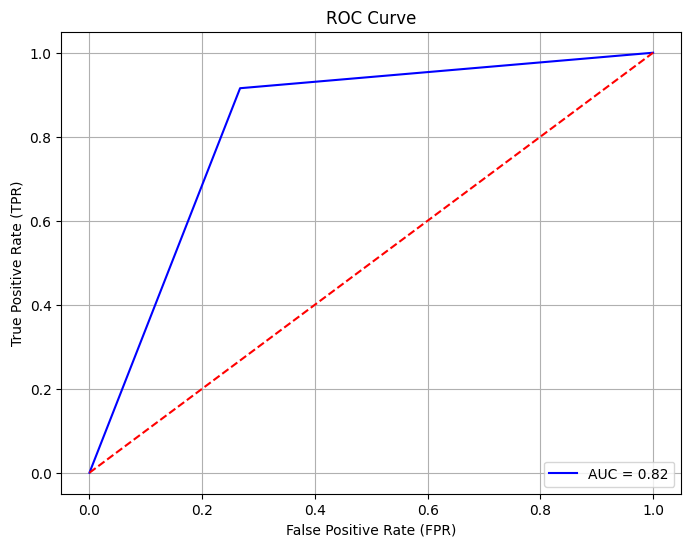

In [87]:
auc = roc_auc_score(y_test, y_pred)

fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

Let us try bayesian optimization instead of guessing


In [72]:


# Define the function to optimize
def xgb_evaluate(n_estimators, learning_rate, max_depth, min_child_weight, subsample, colsample_bytree):
    params = {
        "n_estimators": int(n_estimators),
        "learning_rate": learning_rate,
        "max_depth": int(max_depth),
        "min_child_weight": min_child_weight,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "objective": "binary:logistic",
        "use_label_encoder": False,
        "eval_metric": "logloss",
    }
    
    model = xgb.XGBClassifier(**params)
    scores = cross_val_score(model, x_train, y_train, cv=3, scoring='roc_auc')
    return scores.mean()

# Define the search space for Bayesian Optimization
pbounds = {
    "n_estimators": (50, 1000),
    "learning_rate": (0.01, 1),
    "max_depth": (2, 16),
    "min_child_weight": (1, 15),
    "subsample": (0, 1),
    "colsample_bytree": (0.0, 1),
}

# Run Bayesian Optimization
optimizer = BayesianOptimization(
    f=xgb_evaluate,
    pbounds=pbounds,
    random_state=42,
    verbose=2,
)

optimizer.maximize(init_points=10, n_iter=30)

# Print the best result
print("Best Parameters:", optimizer.max)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | 0.732     | 0.3745    | 0.9512    | 12.25     | 9.381     | 198.2     | 0.156     |
| 2         | 0.8121    | 0.05808   | 0.8675    | 10.42     | 10.91     | 69.56     | 0.9699    |
| 3         | 0.8456    | 0.8324    | 0.2202    | 4.546     | 3.568     | 339.0     | 0.5248    |
| 4         | 0.8359    | 0.4319    | 0.2983    | 10.57     | 2.953     | 327.5     | 0.3664    |
| 5         | 0.5284    | 0.4561    | 0.7873    | 4.795     | 8.199     | 612.8     | 0.04645   |
| 6         | 0.8375    | 0.6075    | 0.1788    | 2.911     | 14.28     | 967.4     | 0.8084    |
| 7         | 0.8534    | 0.3046    | 0.1067    | 11.58     | 7.162     | 165.9     | 0.4952    |
| 8         | 0.7849    | 0.03439   | 0.9102    | 5.623     | 10.28     | 346.1     | 0.5201    |
| 9         | 0.8448

In [73]:
best_params = optimizer.max['params']
best_model = xgb.XGBClassifier(
    n_estimators=int(best_params['n_estimators']),
    learning_rate=best_params['learning_rate'],
    max_depth=int(best_params['max_depth']),
    min_child_weight=best_params['min_child_weight'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    objective="binary:logistic",
    use_label_encoder=False,
    eval_metric="logloss",
    scale_pos_weight= 30/70
)

best_model.fit(x_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5386312379637215, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03204610981412548,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=1.9283264003766525, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=954,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [74]:
# Predict probabilities
y_pred_proba = best_model.predict_proba(x_test)[:, 1]  # Get probabilities for the positive class

# Calculate ROC-AUC score
auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {auc:.4f}")

ROC-AUC Score: 0.8850


In [75]:
# Predict on the test set
y_pred = best_model.predict(x_test)

# Evaluate accuracy
from sklearn.metrics import accuracy_score
accuracy = balanced_accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

Test Accuracy: 0.79


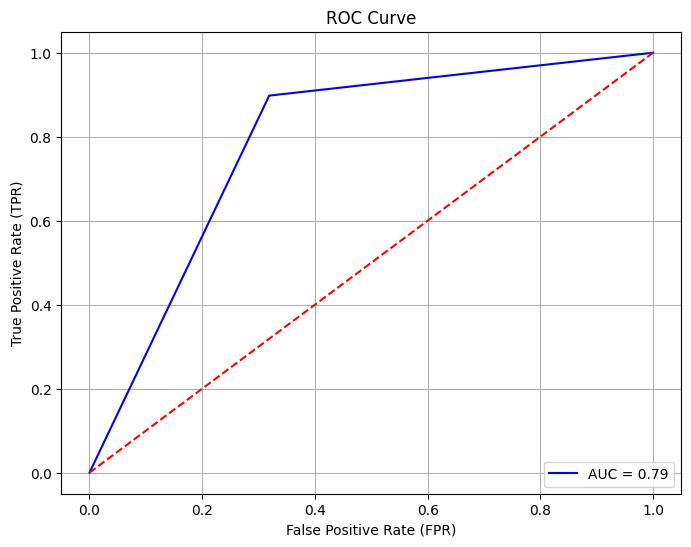

In [79]:
auc = roc_auc_score(y_test, y_pred)

fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()